In [ ]:
from skimage import feature
from imutils import paths
import numpy as np
import argparse
import cv2 as cv
import os
import pandas as pd
from google.colab.patches import cv2_imshow
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB,CategoricalNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from imutils import build_montages

# **Function**

In [ ]:
def preprocess(image, image_size=128):
	image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) # Ubah mehjadi grayscale
	image = cv.resize(image, (image_size, image_size)) # Resize gambar menjadi suatu ukuran (default = 128)
	image = cv.threshold(image, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1] # Melakukan thresholding dan mengambil hasil gambar thresholding
	return image

def quantify_image_hog(image): # Histogram of Oriented Gradient features
	features = feature.hog(image, orientations=9, pixels_per_cell=(10, 10), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1")
	return features

def quantify_image_lbp(image): # Local Binary Pattern features
  features = feature.local_binary_pattern(image, 24, 8, method="uniform")
  (hist, _) = np.histogram(features.flatten(), bins=np.arange(0, 27), range=(0, 26))
  hist = hist.astype("float")
  hist /= (hist.sum() + 1e-7)
  return hist

def load_split(path, image_size=128, extraction_method='hog'):
	image_paths = list(paths.list_images(path))
	data = []
	labels = []

	for image_path in image_paths:
		label = image_path.split(os.path.sep)[-2]

		image = cv.imread(image_path)
		image = preprocess(image, image_size=image_size)
		
		if extraction_method == 'hog':
			features = quantify_image_hog(image)
		elif extraction_method == 'lbp':
			features = quantify_image_lbp(image)
   
		data.append(features)
		labels.append(label)
	return (np.array(data), np.array(labels))
 
def linear_classifier(feature_train,feature_test,label_train,label_test):
  linear_class = LinearSVC(random_state=10)
  linear_class.fit(feature_train, label_train)
  predictions = linear_class.predict(feature_test)

  print(classification_report(label_test, predictions))
  print('Accuracy of linear_classifier on test set: {:.2f}'.format(linear_class.score(feature_test, label_test))) # .score() -> Accuracy
  print("F1", f1_score(label_test, predictions, average="macro"))
  print("Precision", precision_score(label_test, predictions, average="macro"))
  print("Recall", recall_score(label_test, predictions, average="macro"),"\n")
  return

def logreg_classifier(feature_train,feature_test,label_train,label_test):
  logreg_class = LogisticRegression()
  logreg_class.fit(feature_train, label_train)
  predictions = logreg_class.predict(feature_test)

  print(classification_report(label_test, predictions))
  print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg_class.score(feature_test, label_test))) # .score() -> Accuracy
  print("F1", f1_score(label_test, predictions, average="macro"))
  print("Precision", precision_score(label_test, predictions, average="macro"))
  print("Recall", recall_score(label_test, predictions, average="macro"),"\n")
  return

def RandomF_classifier(feature_train,feature_test,label_train,label_test):
  Random_class = RandomForestClassifier(n_estimators=100, random_state=10)
  Random_class.fit(feature_train, label_train)
  predictions = Random_class.predict(feature_test)

  print(classification_report(label_test, predictions))
  print('Accuracy of Random_Forest_classifier on test set: {:.2f}'.format(Random_class.score(feature_test, label_test))) # .score() -> Accuracy
  print("F1", f1_score(label_test, predictions, average="macro"))
  print("Precision", precision_score(label_test, predictions, average="macro"))
  print("Recall", recall_score(label_test, predictions, average="macro"),"\n")
  return 

def Classifier(feature_train,feature_test,label_train,label_test):
  algoritma=[RandomForestClassifier,KNeighborsClassifier,SVC,LinearSVC,GaussianNB,BernoulliNB,LogisticRegression,
             LinearDiscriminantAnalysis,DecisionTreeClassifier,xgb.XGBClassifier]
  
  for index,value in enumerate(algoritma):
    if value == RandomForestClassifier:
      classifier = value(bootstrap=True, max_features = "sqrt",n_estimators=100,random_state=10)
      classifier.fit(feature_train, label_train)
    elif value == KNeighborsClassifier:
      classifier = value(11)
      classifier.fit(feature_train, label_train)
    elif value == SVC:
      kernels=["linear","poly","rbf"]
      for index,value_ker in enumerate(kernels):
        svc_classifier = SVC(kernel = value_ker)
        svc_classifier.fit(feature_train, label_train)
        # prediction
        prediction = svc_classifier.predict(feature_test)
        #hasil
        print(classification_report(label_test, prediction))
        print('Accuracy of SVC with Kernel {} on test set: {:.2f}'.format(value_ker,svc_classifier.score(feature_test, label_test))) # .score() -> Accuracy
        print(f1_score(label_test, prediction, average='macro'))
        print(precision_score(label_test, prediction, average='macro'))
        print(recall_score(label_test, prediction, average='macro'),'\n')
      continue
    elif value == xgb.XGBClassifier:
      classifier = value(learning_rate=0.1)
      classifier.fit(feature_train, label_train)
    else:
      classifier = value()
      classifier.fit(feature_train, label_train)
  
    # prediction
    prediction = classifier.predict(feature_test)
    #hasil
    print(classification_report(label_test, prediction))
    print('Accuracy of {} on test set: {:.2f}'.format(value,classifier.score(feature_test, label_test))) # .score() -> Accuracy
    print(f1_score(label_test, prediction, average='macro'))
    print(precision_score(label_test, prediction, average='macro'))
    print(recall_score(label_test, prediction, average='macro'),'\n')
  return 


# **No. 1**

## **HOG size 128**

In [ ]:
dataset_dir = '/content/drive/My Drive/BCML/foto/parkinsons/wave'

trainingPath = os.path.join(dataset_dir, "training")
testingPath = os.path.join(dataset_dir, "testing")

resize_image_size = 128 
extraction_method = 'hog'

(feature_train, label_train) = load_split(trainingPath, image_size=resize_image_size, extraction_method=extraction_method)
(feature_test, label_test) = load_split(testingPath, image_size=resize_image_size, extraction_method=extraction_method)

le = LabelEncoder()
label_train = le.fit_transform(label_train)
label_test = le.transform(label_test)

# print(feature_train)
# print(feature_test)
# print(label_train)
# print(label_test)

print("Data berhasil didapat!")

Data berhasil didapat!


In [ ]:
linear_classifier(feature_train,feature_test,label_train,label_test)
logreg_classifier(feature_train,feature_test,label_train,label_test)
RandomF_classifier(feature_train,feature_test,label_train,label_test)

In [ ]:
Classifier(feature_train,feature_test,label_train,label_test)

              precision    recall  f1-score   support

           0       0.80      0.53      0.64        15
           1       0.65      0.87      0.74        15

    accuracy                           0.70        30
   macro avg       0.73      0.70      0.69        30
weighted avg       0.72      0.70      0.69        30

Accuracy of <class 'sklearn.ensemble._forest.RandomForestClassifier'> on test set: 0.70
0.6914285714285715
0.7250000000000001
0.7 

              precision    recall  f1-score   support

           0       0.92      0.73      0.81        15
           1       0.78      0.93      0.85        15

    accuracy                           0.83        30
   macro avg       0.85      0.83      0.83        30
weighted avg       0.85      0.83      0.83        30

Accuracy of <class 'sklearn.neighbors._classification.KNeighborsClassifier'> on test set: 0.83
0.8316498316498316
0.8472222222222222
0.8333333333333333 

              precision    recall  f1-score   support

     

In [ ]:
testing_paths = list(paths.list_images(testingPath))
images = []
KN_class = KNeighborsClassifier(11)
KN_class.fit(feature_train, label_train)

for testing_path in testing_paths[:]:
	image = cv.imread(testing_path)
	output = image.copy()
	output = cv.resize(output, (128, 128))

	image = preprocess(image, image_size=resize_image_size)

	if extraction_method == 'hog':
		features = quantify_image_hog(image)
	elif extraction_method == 'lbp':
		features = quantify_image_lbp(image)
   
	preds = KN_class.predict([features])
	label = le.inverse_transform(preds)[0]

	color = (0, 255, 0) if label == "healthy" else (0, 0, 255)
	cv.putText(output, label, (3, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
	images.append(output)

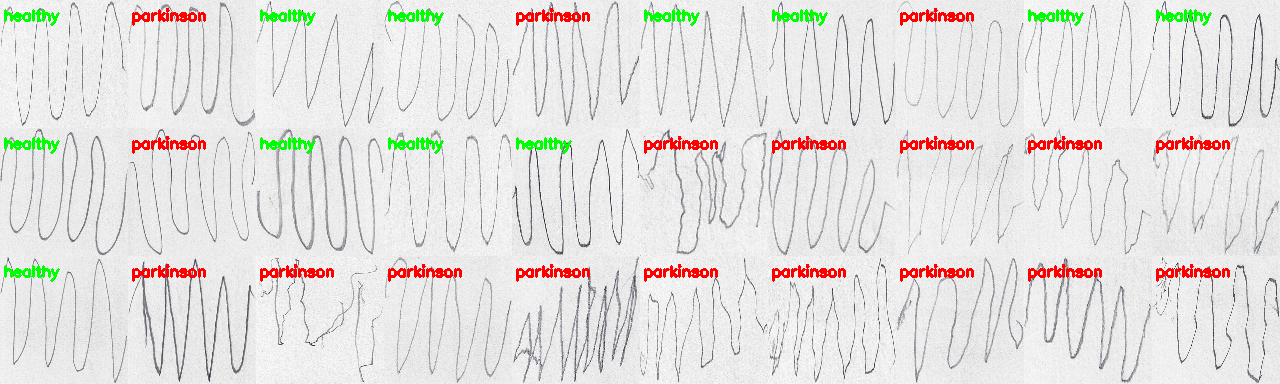

In [ ]:
montage = build_montages(images, (128, 128), (10, 3))[0]
cv2_imshow(montage)

## **HOG size 300**

In [ ]:
dataset_dir = '/content/drive/My Drive/BCML/foto/parkinsons/wave'

trainingPath = os.path.join(dataset_dir, "training")
testingPath = os.path.join(dataset_dir, "testing")

resize_image_size = 300 
extraction_method = 'hog'

(feature_train, label_train) = load_split(trainingPath, image_size=resize_image_size, extraction_method=extraction_method)
(feature_test, label_test) = load_split(testingPath, image_size=resize_image_size, extraction_method=extraction_method)

le = LabelEncoder()
label_train = le.fit_transform(label_train)
label_test = le.transform(label_test)

# print(feature_train)
# print(feature_test)
# print(label_train)
# print(label_test)

print("Data berhasil didapat!")

Data berhasil didapat!


In [ ]:
linear_classifier(feature_train,feature_test,label_train,label_test)
logreg_classifier(feature_train,feature_test,label_train,label_test)
RandomF_classifier(feature_train,feature_test,label_train,label_test)

In [ ]:
Classifier(feature_train,feature_test,label_train,label_test)

              precision    recall  f1-score   support

           0       0.62      0.67      0.65        15
           1       0.64      0.60      0.62        15

    accuracy                           0.63        30
   macro avg       0.63      0.63      0.63        30
weighted avg       0.63      0.63      0.63        30

Accuracy of <class 'sklearn.ensemble._forest.RandomForestClassifier'> on test set: 0.63
0.6329254727474972
0.6339285714285714
0.6333333333333333 

              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.61      0.73      0.67        15

    accuracy                           0.63        30
   macro avg       0.64      0.63      0.63        30
weighted avg       0.64      0.63      0.63        30

Accuracy of <class 'sklearn.neighbors._classification.KNeighborsClassifier'> on test set: 0.63
0.6296296296296295
0.6388888888888888
0.6333333333333333 

              precision    recall  f1-score  

In [ ]:
testing_paths = list(paths.list_images(testingPath))
images = []
linear_class = LinearSVC(random_state=10)
linear_class.fit(feature_train, label_train)

for testing_path in testing_paths[:]:
	image = cv.imread(testing_path)
	output = image.copy()
	output = cv.resize(output, (128, 128))

	image = preprocess(image, image_size=resize_image_size)

	if extraction_method == 'hog':
		features = quantify_image_hog(image)
	elif extraction_method == 'lbp':
		features = quantify_image_lbp(image)
   
	preds = linear_class.predict([features])
	label = le.inverse_transform(preds)[0]

	color = (0, 255, 0) if label == "healthy" else (0, 0, 255)
	cv.putText(output, label, (3, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
	images.append(output)

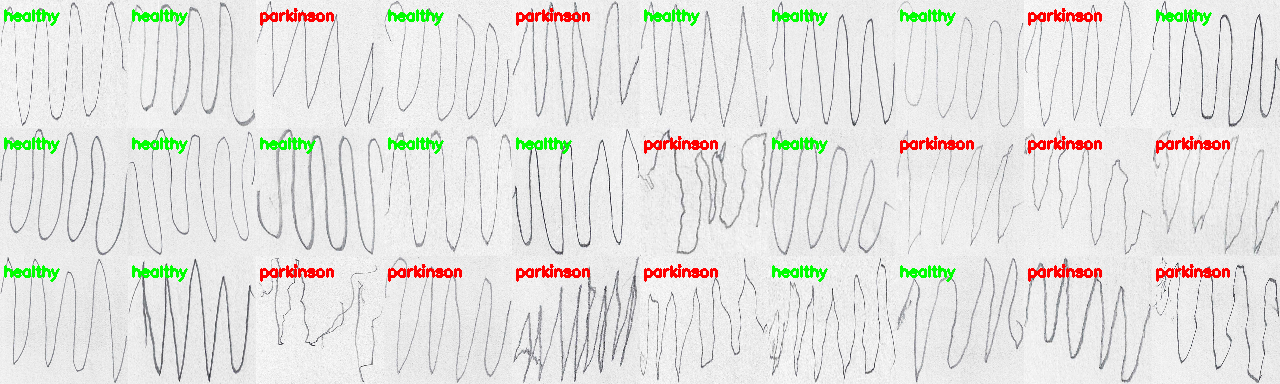

In [ ]:
montage = build_montages(images, (128, 128), (10, 3))[0]
cv2_imshow(montage)

## **LBP size 128**

In [ ]:
dataset_dir = '/content/drive/My Drive/BCML/foto/parkinsons/wave'

trainingPath = os.path.join(dataset_dir, "training")
testingPath = os.path.join(dataset_dir, "testing")

resize_image_size = 128 
extraction_method = 'lbp'

(feature_train, label_train) = load_split(trainingPath, image_size=resize_image_size, extraction_method=extraction_method)
(feature_test, label_test) = load_split(testingPath, image_size=resize_image_size, extraction_method=extraction_method)

le = LabelEncoder()
label_train = le.fit_transform(label_train)
label_test = le.transform(label_test)

# print(feature_train)
# print(feature_test)
# print(label_train)
# print(label_test)

print("Data berhasil didapat!")

Data berhasil didapat!


In [ ]:
linear_classifier(feature_train,feature_test,label_train,label_test)
logreg_classifier(feature_train,feature_test,label_train,label_test)
RandomF_classifier(feature_train,feature_test,label_train,label_test)

In [ ]:
Classifier(feature_train,feature_test,label_train,label_test)

              precision    recall  f1-score   support

           0       0.56      0.60      0.58        15
           1       0.57      0.53      0.55        15

    accuracy                           0.57        30
   macro avg       0.57      0.57      0.57        30
weighted avg       0.57      0.57      0.57        30

Accuracy of <class 'sklearn.ensemble._forest.RandomForestClassifier'> on test set: 0.57
0.5661846496106784
0.5669642857142857
0.5666666666666667 

              precision    recall  f1-score   support

           0       0.53      0.53      0.53        15
           1       0.53      0.53      0.53        15

    accuracy                           0.53        30
   macro avg       0.53      0.53      0.53        30
weighted avg       0.53      0.53      0.53        30

Accuracy of <class 'sklearn.neighbors._classification.KNeighborsClassifier'> on test set: 0.53
0.5333333333333333
0.5333333333333333
0.5333333333333333 

              precision    recall  f1-score  

In [ ]:
testing_paths = list(paths.list_images(testingPath))
images = []
BernoulliNB_class = BernoulliNB()
BernoulliNB_class.fit(feature_train, label_train)

for testing_path in testing_paths[:]:
	image = cv.imread(testing_path)
	output = image.copy()
	output = cv.resize(output, (128, 128))

	image = preprocess(image, image_size=resize_image_size)

	if extraction_method == 'hog':
		features = quantify_image_hog(image)
	elif extraction_method == 'lbp':
		features = quantify_image_lbp(image)
   
	preds = BernoulliNB_class.predict([features])
	label = le.inverse_transform(preds)[0]

	color = (0, 255, 0) if label == "healthy" else (0, 0, 255)
	cv.putText(output, label, (3, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
	images.append(output)

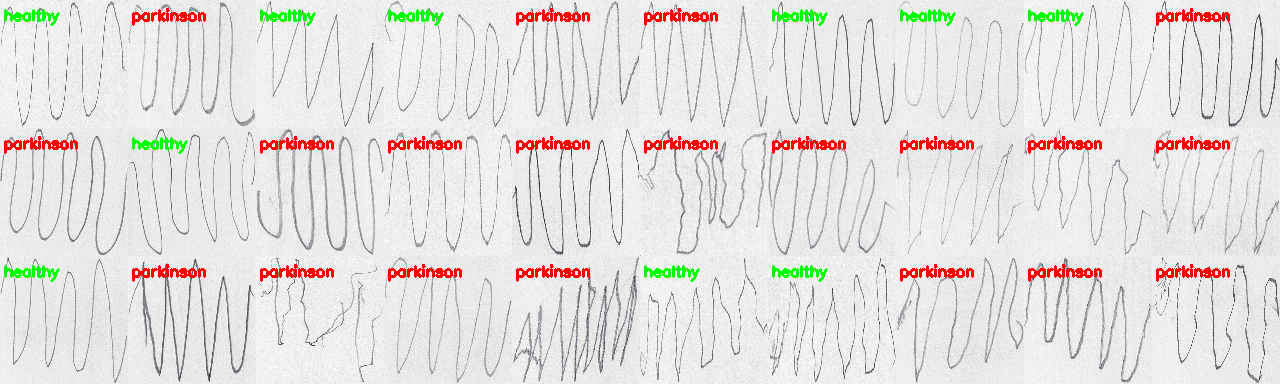

In [ ]:
montage = build_montages(images, (128, 128), (10, 3))[0]
cv2_imshow(montage)

## **LBP size 300**

In [ ]:
dataset_dir = '/content/drive/My Drive/BCML/foto/parkinsons/wave'

trainingPath = os.path.join(dataset_dir, "training")
testingPath = os.path.join(dataset_dir, "testing")

resize_image_size = 300 
extraction_method = 'lbp'

(feature_train, label_train) = load_split(trainingPath, image_size=resize_image_size, extraction_method=extraction_method)
(feature_test, label_test) = load_split(testingPath, image_size=resize_image_size, extraction_method=extraction_method)

le = LabelEncoder()
label_train = le.fit_transform(label_train)
label_test = le.transform(label_test)

# print(feature_train)
# print(feature_test)
# print(label_train)
# print(label_test)

print("Data berhasil didapat!")

Data berhasil didapat!


In [ ]:
linear_classifier(feature_train,feature_test,label_train,label_test)
logreg_classifier(feature_train,feature_test,label_train,label_test)
RandomF_classifier(feature_train,feature_test,label_train,label_test)

In [ ]:
Classifier(feature_train,feature_test,label_train,label_test)

              precision    recall  f1-score   support

           0       0.71      0.67      0.69        15
           1       0.69      0.73      0.71        15

    accuracy                           0.70        30
   macro avg       0.70      0.70      0.70        30
weighted avg       0.70      0.70      0.70        30

Accuracy of <class 'sklearn.ensemble._forest.RandomForestClassifier'> on test set: 0.70
0.6996662958843158
0.7008928571428572
0.7 

              precision    recall  f1-score   support

           0       0.64      0.60      0.62        15
           1       0.62      0.67      0.65        15

    accuracy                           0.63        30
   macro avg       0.63      0.63      0.63        30
weighted avg       0.63      0.63      0.63        30

Accuracy of <class 'sklearn.neighbors._classification.KNeighborsClassifier'> on test set: 0.63
0.6329254727474972
0.6339285714285714
0.6333333333333333 

              precision    recall  f1-score   support

     

In [ ]:
testing_paths = list(paths.list_images(testingPath))
images = []
Random_class = RandomForestClassifier(n_estimators=100, random_state=10)
Random_class.fit(feature_train, label_train)

for testing_path in testing_paths[:]:
	image = cv.imread(testing_path)
	output = image.copy()
	output = cv.resize(output, (128, 128))

	image = preprocess(image, image_size=resize_image_size)

	if extraction_method == 'hog':
		features = quantify_image_hog(image)
	elif extraction_method == 'lbp':
		features = quantify_image_lbp(image)
   
	preds = Random_class.predict([features])
	label = le.inverse_transform(preds)[0]

	color = (0, 255, 0) if label == "healthy" else (0, 0, 255)
	cv.putText(output, label, (3, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
	images.append(output)

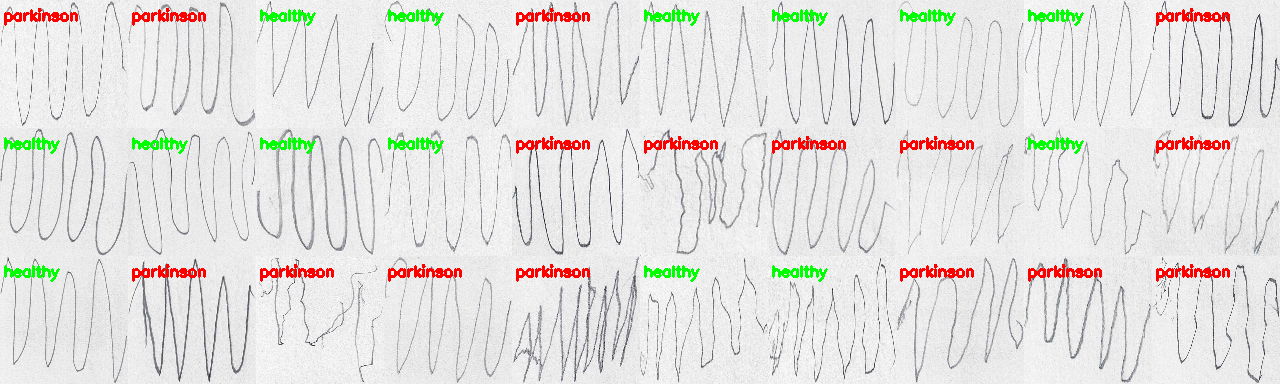

In [ ]:
montage = build_montages(images, (128, 128), (10, 3))[0]
cv2_imshow(montage)

## **Kesimpulan**

Berdasarkan hasil percobaan Feature extractor HOG (Histogram of Oriented Gradient) dan LBP (Local Binary Pattern) di atas untuk nilai akurasi terbaik dari masing-masing kondisi ialah:

HOG size 128: 83% menggunakan KNN dengan n=11

HOG size 300: 73% menggunakan LinearSVC

LBP size 128: 63% menggunakan BernoulliNB

LBP size 300: 70% menggunakan RandomForestClassifier dengan n_estimator=100 dan randomstate=10

bila di bandingkan seluruhnya maka lebih baik menggunakan Feature extractor HOG size 128 dengan method KNN n = 11 


# **No. 2**

## **Memasukan data Baru (healthy)**

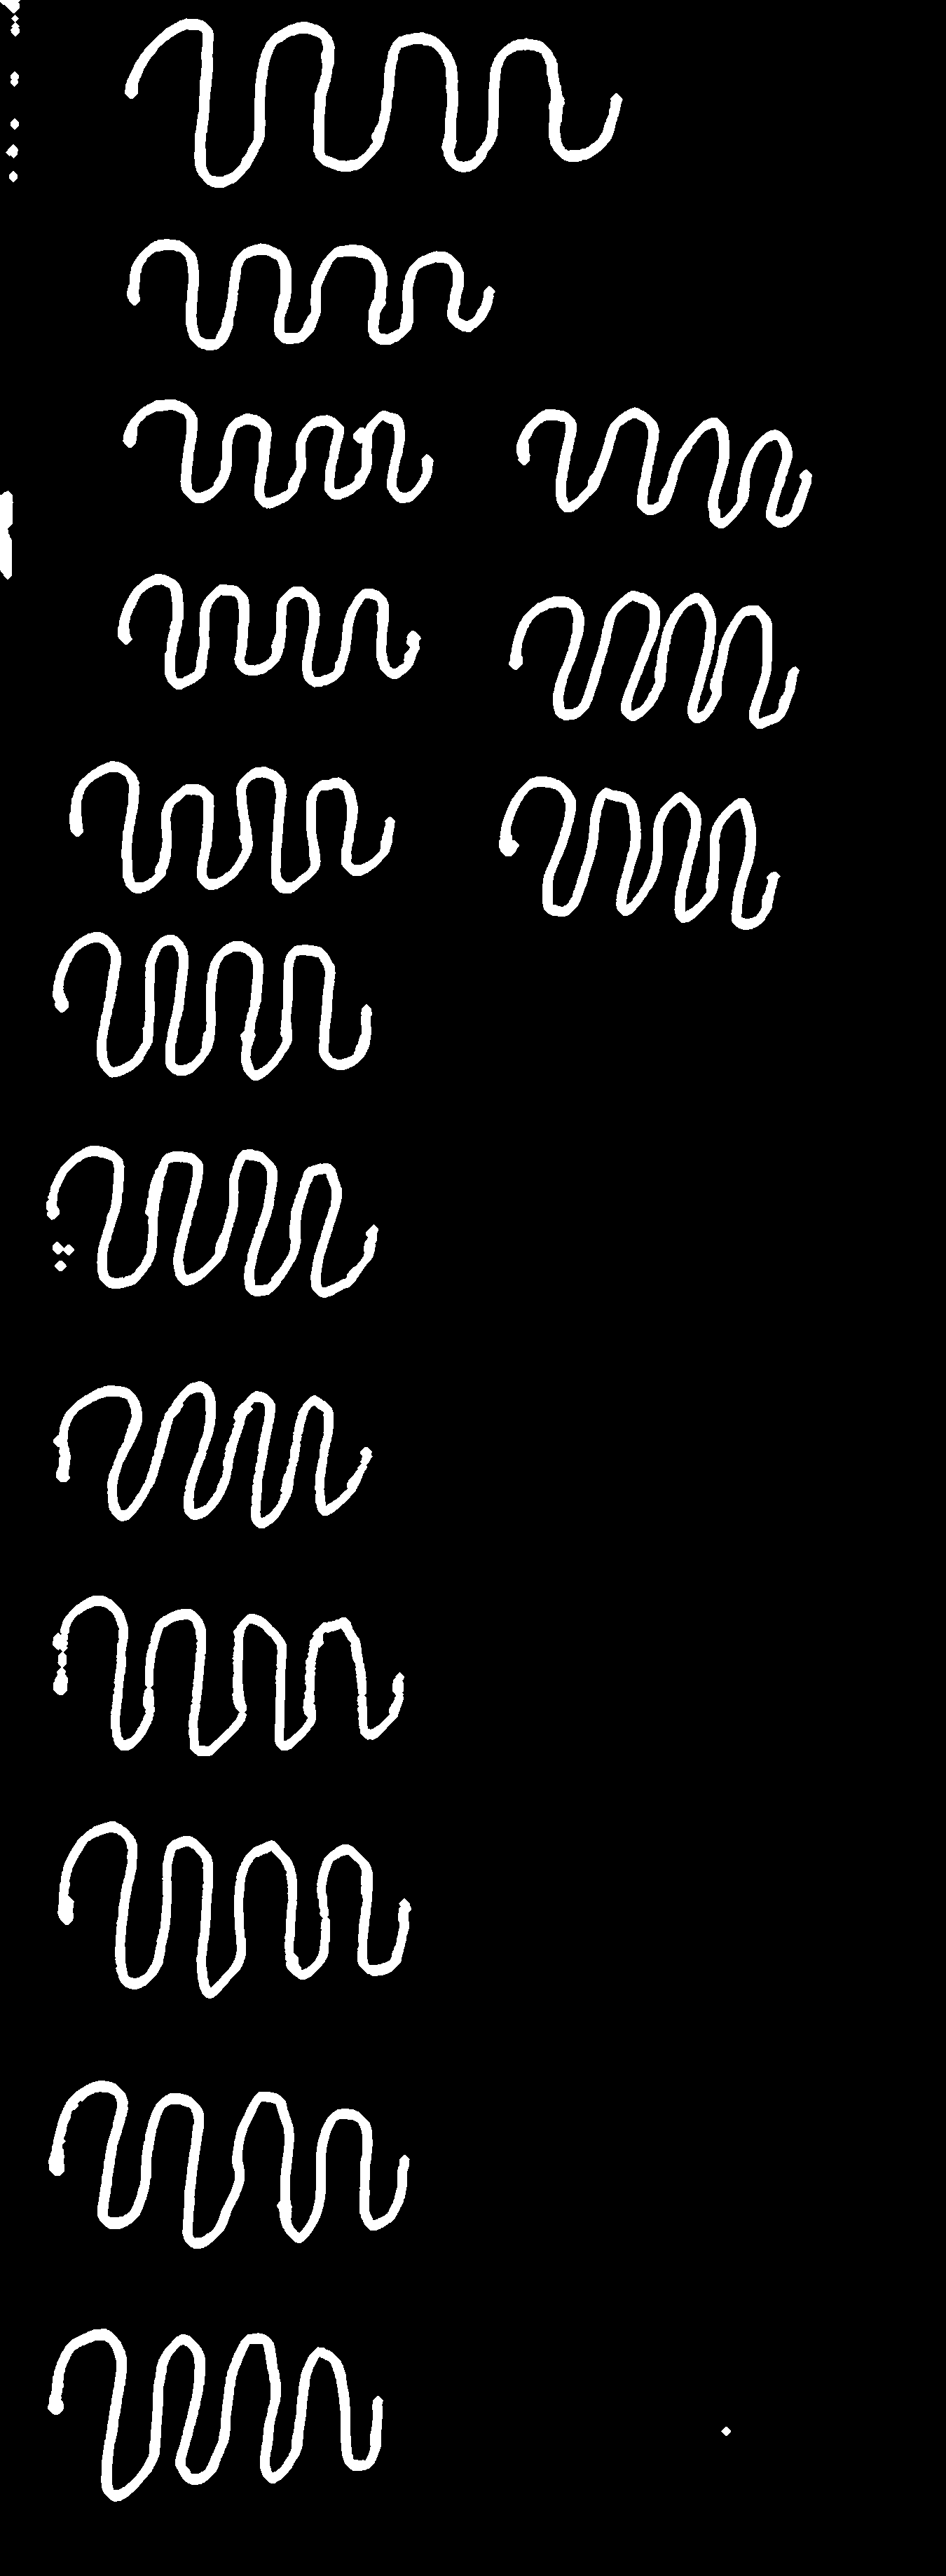

index     area  width  height
22     22  27626.5    711     242
1       1  24947.5    479     247
2       2  24453.5    516     240
3       3  24165.5    505     253
8       8  23227.0    474     217
9       9  22515.0    456     212
4       4  21917.0    502     229
5       5  21633.5    456     210
10     10  21256.0    402     219
12     12  20674.5    415     197
11     11  19860.5    465     189
17     17  18596.0    526     159
15     15  17275.5    422     173
13     13  17074.5    433     165
16     16  16268.0    444     156
14     14   1862.0     19     127
7       7    315.0     31      20
24     24    306.0     29      19
23     23    203.5     13      31
19     19    186.0     18      20
21     21    163.5     12      22
6       6    151.0     17      15
18     18    115.0     12      16
20     20    115.0     12      16
0       0     95.0     14      13

In [ ]:
image = cv.imread('/content/drive/My Drive/BCML/foto/parkinsons/sehat_revisi.png')

def gaus_filter(image,kernel):
  blur = cv.GaussianBlur(image, (kernel, kernel), 0)
  return blur

def filtering_median(image,kernel):
  blur = cv.medianBlur(image, kernel)
  return blur

image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

image_gray_blur= filtering_median(image_gray,3)

# cv2_imshow(image_gray_blur)

thresholding_value, thresholding_result = cv.threshold(image_gray_blur, 100, 255, cv.THRESH_BINARY)

# print(thresholding_value)
# cv2_imshow(thresholding_result)

thresholding_result = cv.bitwise_not(thresholding_result)
# cv2_imshow(thresholding_result)
dilation = cv.dilate(thresholding_result,kernel,iterations = 5)
cv2_imshow(dilation)
contours, hierarchy = cv.findContours(dilation, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
# print(contours)

area_array=[]
for index, contour in enumerate(contours):
  x, y, w, h = cv.boundingRect(contour)
  area = cv.contourArea(contour)
  area_array.append([index,area,w,h])
  # print("Contour #" + str(index), x, y, w, h, area)

df_area=pd.DataFrame(area_array)
df_area.columns = ['index','area','width','height']
df_sort=df_area.sort_values(by=['area'],ascending=False)
df_sort.head(50)

In [ ]:
test = df_area['area']
array=[]
directory_save = '/content/drive/My Drive/BCML/foto/parkinsons/wave/training/healthy'

for i,v in enumerate(test):
    if test[i] >16000:
      array.append(i)

array.sort()
print(array)
os.chdir(directory_save) 

for i,v in enumerate(array): 
  x, y, w, h = cv.boundingRect(contours[v])
  wave = image[y:y+h, x:x+w]
  resized = cv.resize(wave, (512,220), interpolation = cv.INTER_AREA)
  cv.imwrite('wave{}.png'.format(i), resized)

print(os.listdir(directory_save))

[1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 15, 16, 17, 22]
['V02HO02.png', 'V02HO03.png', 'V03HO02.png', 'V03HO03.png', 'V08HO02.png', 'V08HO03.png', 'V09HO02.png', 'V09HO03.png', 'V05HO02.png', 'V05HO03.png', 'V12HO01.png', 'V12HO02.png', 'V12HO03.png', 'V11HO02.png', 'V11HO03.png', 'V10HO02.png', 'V10HO03.png', 'V07HO02.png', 'V07HO03.png', 'V06HO02.png', 'V06HO03.png', 'V01HO02.png', 'V01HO03.png', 'V04HO02.png', 'V04HO03.png', 'V55HO01.png', 'V55HO02.png', 'V55HO03.png', 'V55HO04.png', 'V55HO05.png', 'V55HO06.png', 'V55HO07.png', 'V55HO12.png', 'V55HO13.png', 'V55HO14.png', 'V55HO15.png', 'wave0.png', 'wave1.png', 'wave2.png', 'wave3.png', 'wave4.png', 'wave5.png', 'wave6.png', 'wave7.png', 'wave8.png', 'wave9.png', 'wave10.png', 'wave11.png', 'wave12.png', 'wave13.png', 'wave14.png']


## **Memasukan Data Baru (Parkinsons)**

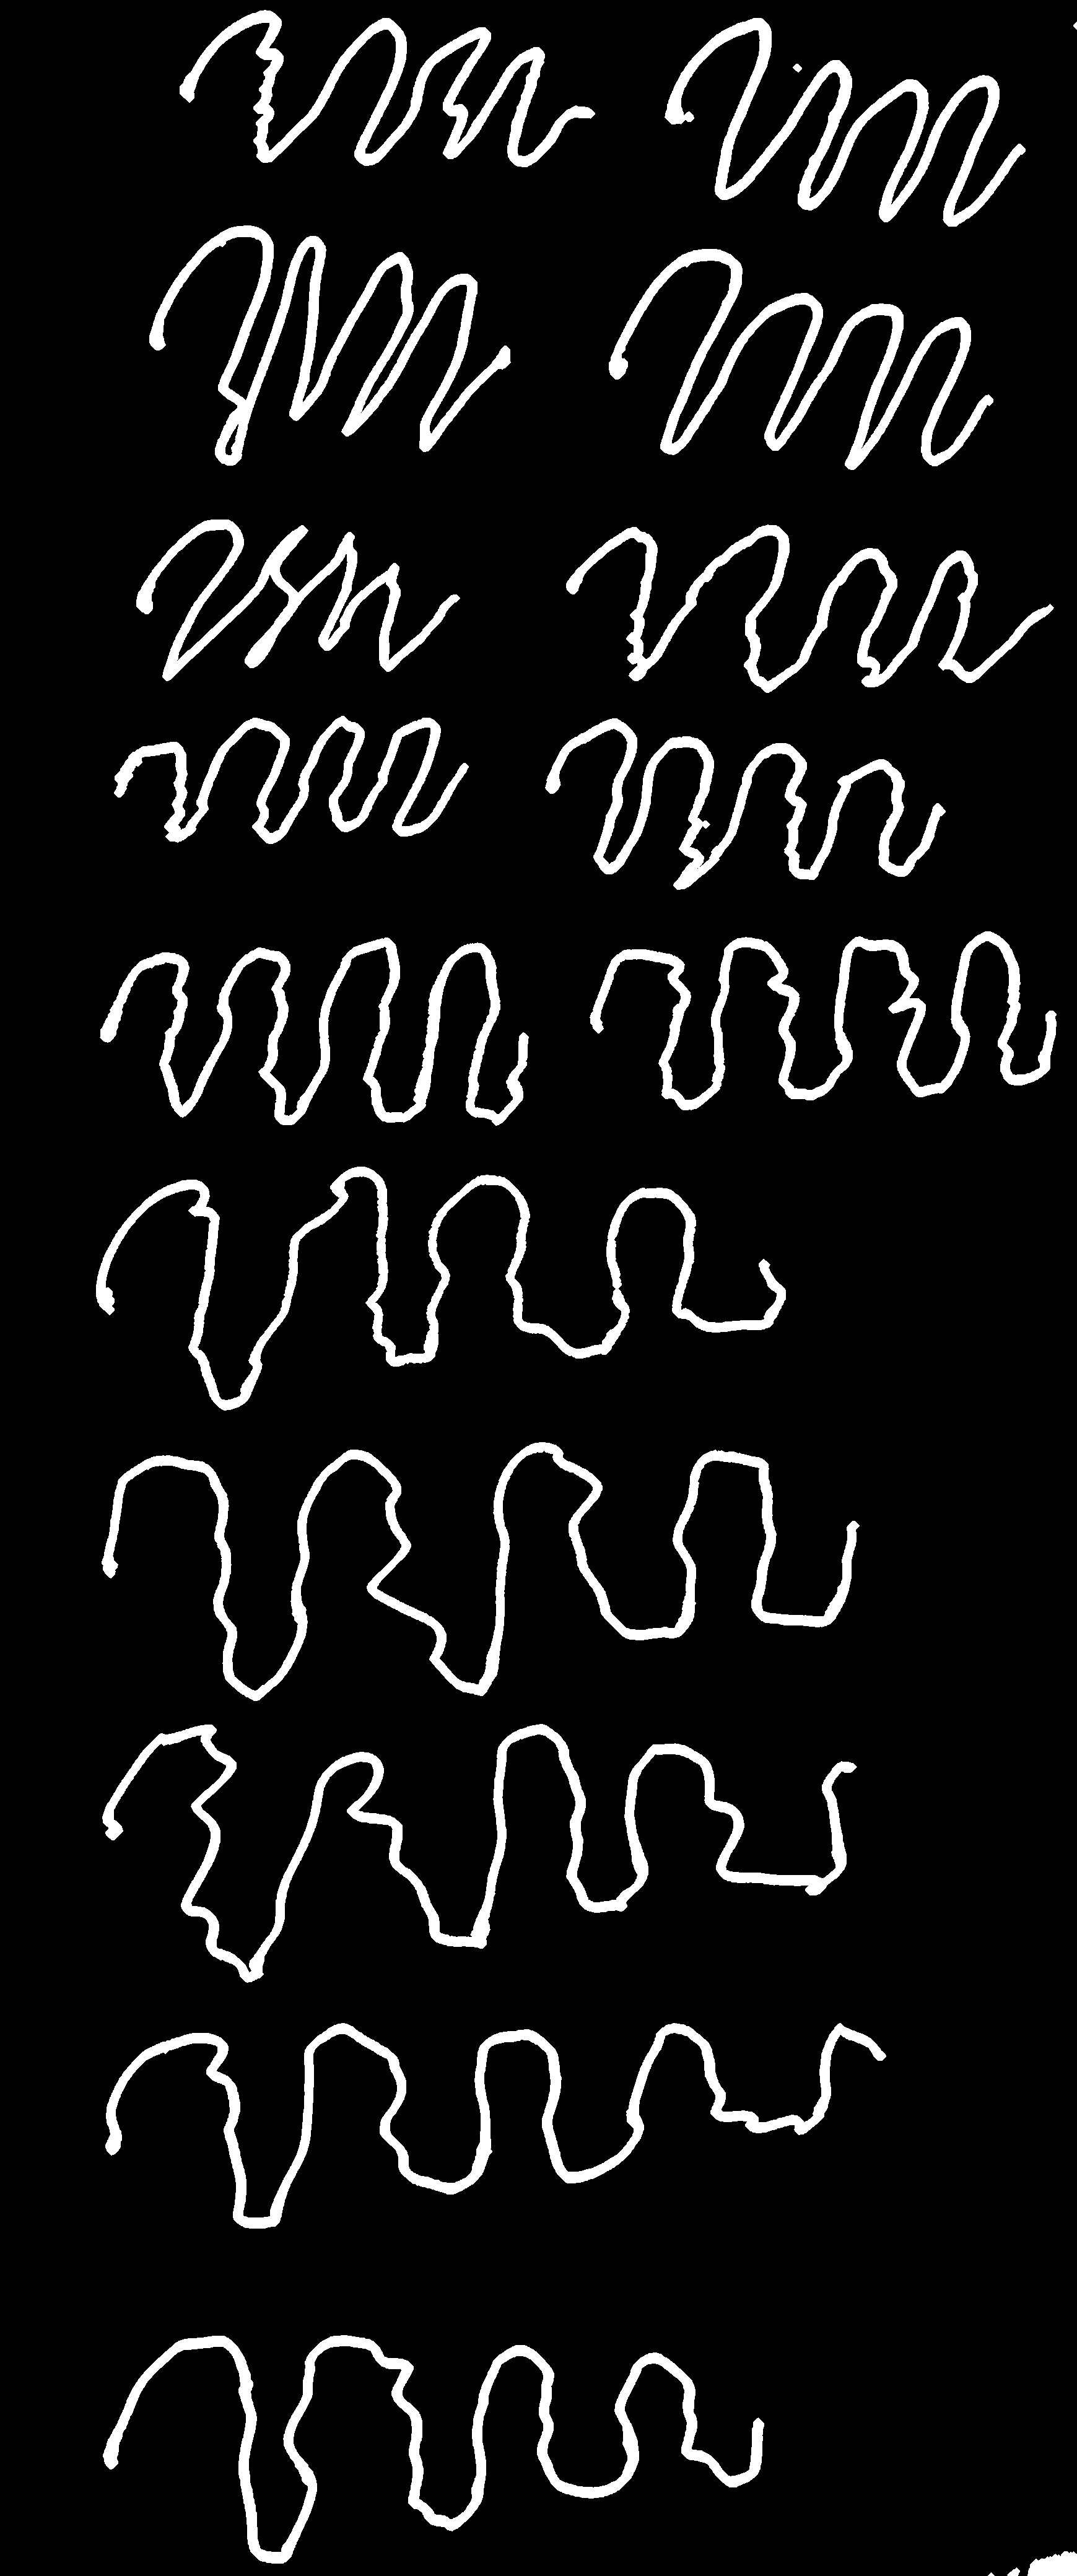

index     area  width  height
6       6  51850.5   1224     418
5       5  51637.5   1219     418
3       3  45397.0   1068     369
4       4  45151.5   1261     332
7       7  44256.0   1114     394
15     15  42467.5    584     388
8       8  38598.0    693     304
14     14  37823.0    621     357
9       9  37542.5    754     289
18     18  36378.0    583     337
19     19  33433.5    671     254
12     12  33113.5    788     272
10     10  31211.5    647     277
13     13  26667.0    523     261
11     11  25755.5    573     207
2       2   2387.5     80      40
1       1    150.5     21      14
16     16    112.5     15      14
17     17     35.0      6      13
0       0     25.0     11       6

In [ ]:
image = cv.imread('/content/drive/My Drive/BCML/foto/parkinsons/parkinson_revisi2.png')

def gaus_filter(image,kernel):
  blur = cv.GaussianBlur(image, (kernel, kernel), 0)
  return blur

def filtering_median(image,kernel):
  blur = cv.medianBlur(image, kernel)
  return blur

image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

image_gray_blur= filtering_median(image_gray,3)

# cv2_imshow(image_gray_blur)

thresholding_value, thresholding_result = cv.threshold(image_gray_blur, 100, 255, cv.THRESH_BINARY)

# print(thresholding_value)
# cv2_imshow(thresholding_result)
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,3))
thresholding_result = cv.bitwise_not(thresholding_result)
# cv2_imshow(thresholding_result)
dilation = cv.dilate(thresholding_result,kernel,iterations = 5)
cv2_imshow(dilation)
contours, hierarchy = cv.findContours(dilation, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
# print(contours)

area_array=[]
for index, contour in enumerate(contours):
  x, y, w, h = cv.boundingRect(contour)
  area = cv.contourArea(contour)
  area_array.append([index,area,w,h])
  # print("Contour #" + str(index), x, y, w, h, area)

df_area=pd.DataFrame(area_array)
df_area.columns = ['index','area','width','height']
df_sort=df_area.sort_values(by=['area'],ascending=False)
df_sort.head(50)

In [ ]:
test = df_area['area']
array=[]
directory_save = '/content/drive/My Drive/BCML/foto/parkinsons/wave/training/parkinson'

for i,v in enumerate(test):
    if test[i] >20000:
      array.append(i)

array.sort()
print(array)
os.chdir(directory_save) 

for i,v in enumerate(array): 
  x, y, w, h = cv.boundingRect(contours[v])
  wave = image[y:y+h, x:x+w]
  # cv2_imshow(wave)
  resized = cv.resize(wave, (512,220), interpolation = cv.INTER_AREA)
  cv.imwrite('wave{}.png'.format(i), resized)

print(os.listdir(directory_save))

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19]
['V05PO02.png', 'V05PO03.png', 'V01PO02.png', 'V01PO03.png', 'V13PO01.png', 'V13PO02.png', 'V13PO03.png', 'V03PO02.png', 'V03PO03.png', 'V03PO05.png', 'V03PO06.png', 'V03PO08.png', 'V03PO09.png', 'V08PO02.png', 'V08PO03.png', 'V10PO02.png', 'V10PO03.png', 'V07PO02.png', 'V07PO03.png', 'V11PO02.png', 'V11PO03.png', 'V09PO02.png', 'V09PO03.png', 'V14PO02.png', 'V12PO01.png', 'V12PO02.png', 'V12PO03.png', 'V15PO01.png', 'V15PO02.png', 'V15PO03.png', 'V06PO02.png', 'V06PO03.png', 'V02PO02.png', 'V02PO03.png', 'V04PO02.png', 'V04PO03.png', 'wave0.png', 'wave1.png', 'wave2.png', 'wave3.png', 'wave4.png', 'wave5.png', 'wave6.png', 'wave7.png', 'wave8.png', 'wave9.png', 'wave10.png', 'wave11.png', 'wave12.png', 'wave13.png', 'wave14.png']


## **Melakukan tes dengan HOG size 128**

In [ ]:
dataset_dir = '/content/drive/My Drive/BCML/foto/parkinsons/wave'

trainingPath = os.path.join(dataset_dir, "training")
testingPath = os.path.join(dataset_dir, "testing")

resize_image_size = 128 
extraction_method = 'hog'

(feature_train, label_train) = load_split(trainingPath, image_size=resize_image_size, extraction_method=extraction_method)
(feature_test, label_test) = load_split(testingPath, image_size=resize_image_size, extraction_method=extraction_method)

le = LabelEncoder()
label_train = le.fit_transform(label_train)
label_test = le.transform(label_test)

# print(feature_train)
# print(feature_test)
# print(label_train)
# print(label_test)

print("Data berhasil didapat!")

Data berhasil didapat!


In [ ]:
Classifier(feature_train,feature_test,label_train,label_test)

              precision    recall  f1-score   support

           0       0.73      0.53      0.62        15
           1       0.63      0.80      0.71        15

    accuracy                           0.67        30
   macro avg       0.68      0.67      0.66        30
weighted avg       0.68      0.67      0.66        30

Accuracy of <class 'sklearn.ensemble._forest.RandomForestClassifier'> on test set: 0.67
0.6606334841628959
0.6794258373205742
0.6666666666666667 

              precision    recall  f1-score   support

           0       0.86      0.80      0.83        15
           1       0.81      0.87      0.84        15

    accuracy                           0.83        30
   macro avg       0.83      0.83      0.83        30
weighted avg       0.83      0.83      0.83        30

Accuracy of <class 'sklearn.neighbors._classification.KNeighborsClassifier'> on test set: 0.83
0.8331479421579533
0.8348214285714286
0.8333333333333334 

              precision    recall  f1-score  

In [ ]:
testing_paths = list(paths.list_images(testingPath))
images = []
KN_class = KNeighborsClassifier(11)
KN_class.fit(feature_train, label_train)

for testing_path in testing_paths[:]:
	image = cv.imread(testing_path)
	output = image.copy()
	output = cv.resize(output, (128, 128))

	image = preprocess(image, image_size=resize_image_size)

	if extraction_method == 'hog':
		features = quantify_image_hog(image)
	elif extraction_method == 'lbp':
		features = quantify_image_lbp(image)
   
	preds = KN_class.predict([features])
	label = le.inverse_transform(preds)[0]

	color = (0, 255, 0) if label == "healthy" else (0, 0, 255)
	cv.putText(output, label, (3, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
	images.append(output)

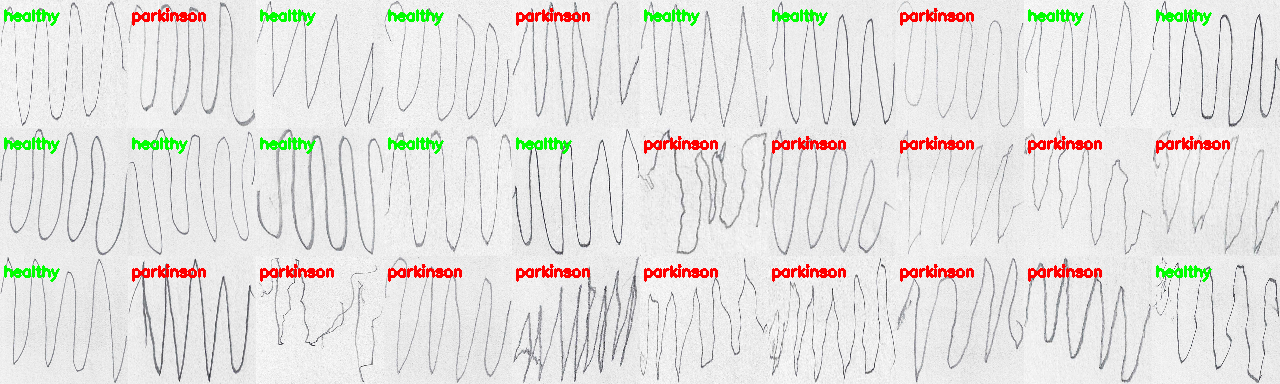

In [ ]:
montage = build_montages(images, (128, 128), (10, 3))[0]
cv2_imshow(montage)

## **Kesimpulan**

**Sebelum Penambahan:**
```
RandomForestClassifier on test set: 0.70

KNeighborsClassifier on test set: 0.83
0.8316498316498316
0.8472222222222222
0.8333333333333333

SVC with Kernel linear on test set: 0.67
SVC with Kernel poly on test set: 0.73
SVC with Kernel rbf on test set: 0.73
LinearSVC on test set: 0.67
GaussianNB on test set: 0.63
BernoulliNB on test set: 0.73
LogisticRegression on test set: 0.67
LinearDiscriminantAnalysis on test set: 0.70
DecisionTreeClassifier on test set: 0.60
XGBClassifier on test set: 0.57
```



**Setelah Penambahan:**
```
RandomForestClassifier on test set: 0.67
KNeighborsClassifier on test set: 0.83
0.8331479421579533
0.8348214285714286
0.8333333333333334

SVC with Kernel linear on test set: 0.77
SVC with Kernel poly on test set: 0.70
SVC with Kernel rbf on test set: 0.70
LinearSVC on test set: 0.70
GaussianNB'on test set: 0.67
BernoulliNB on test set: 0.73
LogisticRegression on test set: 0.73
LinearDiscriminantAnalysis on test set: 0.67
DecisionTreeClassifier on test set: 0.70
XGBClassifier on test set: 0.70
```

Terjadi beberapa perubahan pada hasil akurasi yang dapat di lihat pada kolom di atas tetapi untuk akurasi KNN sendiri tidak berubah jauh. tetapi untuk uang lainnya memang terlihat kenaikan seperti XGB dan svc dengan kernel linear. berarti memang benar bahwa penambahan data training mempengaruhi hasil akurasi dan dalam kasus ini mempengaruhi dalam pengambilan keputusan berdasarkan hasil foto tulisan seseorang apakah orang tersebut termasuk parkinsons atau tidak.
